<div align="center">

# Physics-Informed Neural Networks (PINNs)

## Projet SOIA 6.1
</div>

Oscar Agnus, SOIA A3


<div align="center">

# 1D Heat Equation, stationary

</div>

Here, we try to simulate the 1D heat equation using a physics-informed neural network (PINN). The heat equation is given by:
$$
\nu \frac{\partial^2 u}{\partial x^2} = f(x)
$$

where $u$ is the temperature,
$x$ is the space coordinate,
$t$ is the time coordinate,
and $\nu$ is the thermal diffusivity.


In [7]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import time
from datetime import timedelta

# Weights and Biases - this is for logging the results
import wandb

def display_time(seconds):
    """Convert seconds to a time string 00h 00min 00s"""
    delta = timedelta(seconds=seconds)
    hours, remainder = divmod(delta.seconds, 3600)
    minutes, seconds = divmod(remainder, 60)
    return f"{hours:02}h {minutes:02}min {seconds:02}s"

## Setting up the problem

Here, we define the problem in physical terms, and format it so that it can be used by the neural network.

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleNetwork(nn.Module):
    """Custom neural network with 8 hidden layers."""
    def __init__(self, input_size):
        super(SimpleNetwork, self).__init__()
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, 20) if i == 0 else nn.Linear(20, 20) for i in range(8)])
        self.output_layer = nn.Linear(20, input_size)

    def forward(self, x):
        for layer in self.hidden_layers:
            x = torch.tanh(layer(x))
        x = self.output_layer(x)
        return x

## Problem definition
We define the problem in physical terms, and format it so that it can be used by the neural network.

In [9]:
# Space domain
x_min = 0
x_max = 1
N_x = 1000 # Number of points in the space domain
X = np.linspace(x_min, x_max, N_x) # Discretized space domain
X_bc = np.array([x_min, x_max]) # Boundary conditions points


# Define useful parameters
nu = 0.01 # Thermal diffusivity

def f(x):
    """Source of the heat equation."""
    return torch.zeros_like(x)

def u_ic(x):
    """Initial conditions for the heat equation."""
    return np.sin(np.pi*x)

def u_bound_cond(x):
    """Boundary conditions for the 1D heat equation.
    :param x: space domain, discretized"""
    u = np.zeros_like(x)
    u[0][0][0] = -1
    u[0][0][-1] = 1
    return u

def open_boundary(N, x_0, x_1, u_0=0, u_1=1):
    x = torch.cat([torch.ones(N // 2) * x_0, torch.ones(N // 2) * x_1], dim=0)
    u = torch.cat([torch.ones(N // 2) * u_0, torch.ones(N // 2) * u_1], dim=0)
    return x, u

def u_exact(x):
    """Exact solution of the heat equation (or the finite element solution).
    The solution is given for each instant, and the space domain can be multidimensional.
    :param x: space domain, discretized
    :param t: time domain, discretized"""
    A = 1 # Initial conditions
    B = 0 # Boundary conditions
    u = A*x + B
    # u = u.to(device) # not sure this is necessary
    return u

## Neural network design
We define the neural network that will approximate the solution of the heat equation.

In [10]:
# Define the model
# my_model = models.resnet18()
# my_model = ResNet18()

# my_model = SimpleNetwork(N_x)

# Nombre de dimensions en entrées (1 pour un vecteur)
my_model = torch.nn.Sequential(
    torch.nn.Linear(1, 20),
    torch.nn.Tanh(),
    torch.nn.Linear(20, 20),
    torch.nn.Tanh(),
    torch.nn.Linear(20, 20),
    torch.nn.Tanh(),
    torch.nn.Linear(20, 20),
    torch.nn.Tanh(),
    torch.nn.Linear(20, 20),
    torch.nn.Tanh(),    
    torch.nn.Linear(20, 20),
    torch.nn.Tanh(),
    torch.nn.Linear(20, 20),
    torch.nn.Tanh(),
    torch.nn.Linear(20, 20),
    torch.nn.Tanh(),
    torch.nn.Linear(20, 20),
    torch.nn.Tanh(),
    torch.nn.Linear(20, 1),
)


# Checkpoint
my_model_checkpoint = my_model

# Summary of the model
# print(my_model)

## Loss functions
Here are defined the loss functions. There are 3 different loss functions:
- $L_{data}$ : loss function for the data points
- $L_{bc}$ &nbsp; &nbsp;: loss function for the boundary conditions
- $L_{pde}$ : loss function for the PDE

All of them use the Mean Squared Error (MSE) with the given data points.
Each one of them will be used with their relative weight, which represent their importance in the composite loss function $L_{composite}$.

In [11]:
# Gradient function
def grad(outputs, inputs):
    """Compute the gradient of 'outputs' with respect to 'inputs'."""
    return torch.autograd.grad(outputs = outputs, inputs = inputs, grad_outputs = torch.ones_like(outputs), create_graph = True)[0]

# Loss functions
def loss_data(u_pred, u_gt):
    """Loss function for the data points."""
    return torch.nn.MSELoss()(u_pred, u_gt)
    
def loss_bc(u_pred, u_bc):
    """Loss function for the boundary conditions."""
    return torch.nn.MSELoss()(u_pred, u_bc)

def loss_pde(u_pred, x_pde):
    """Loss function for the PDE.
    Needs to be changed in case of a different PDE."""
    u_x  = grad(u_pred, x_pde) # First order derivative
    u_xx = grad(u_x, x_pde)    # Second order derivative
    return torch.nn.MSELoss()(nu*u_xx, f(x_pde))

def loss_composite(u_gt, u_pred, u_bc, u_bc_pred, x_pde):
    """Composite loss function, combining the three loss functions."""
    # Weights for the composite loss function
    w_data = 0.0
    w_bc   = 1.0
    w_pde  = 1.0
    return w_data*loss_data(u_pred, u_gt) + w_bc*loss_bc(u_bc_pred, u_bc) + w_pde*loss_pde(u_pred, x_pde)

## Training and testing functions
Here we define the training and testing functions. We want to make a checkpoint of the model when the testing loss is minimal.

In [12]:
def train(model, model_checkpoint, optimizer, number_epoch):
    """Training function for the model."""
    model.train() # Set the model to training mode

    # Collocation points
    inputs = torch.rand(2000, requires_grad=True) # Collocation points, randomly distributed in the space domain
    inputs = inputs.unsqueeze(-1) # Add a dimension for the space domain
    inputs = inputs.to(device)    # Send the inputs to the device (GPU or CPU)

    # Boundary conditions
    inputs_bc, u_bc = open_boundary(1000, x_min, x_max) # Boundary conditions
    inputs_bc = inputs_bc.float().unsqueeze(-1) # Add a dimension for the space domain
    u_bc = u_bc.float().unsqueeze(-1)           # Add a dimension for the space domain
    inputs_bc = inputs_bc.to(device)    # Send the inputs to the device (GPU or CPU)
    u_bc = u_bc.to(device)              # Send the values to the device (GPU or CPU)

    # Array to store the losses during the training
    train_loss = np.array([])

    # Training loop
    for n in range(number_epoch):
        t_0 = time.time()
        optimizer.zero_grad()           # Zero the parameter gradients
        outputs = model(inputs)         # Forward pass for the collocation points
        outputs_bc = model(inputs_bc)   # Forward pass for the boundary
        
        loss = loss_composite(u_exact(inputs), outputs, u_bc, outputs_bc, inputs)
        loss.backward()                # Backward pass
        optimizer.step()
        train_loss = np.append(train_loss, loss.item())

        # Checkpoint
        if loss.item() <= np.min(train_loss):
            model_checkpoint = model
            torch.save(model.state_dict(), "PINN_1D_heat_eq_stat_model_checkpoint.pth")

        # Display time
        deltat = []
        t_1 = time.time()
        deltat.append(t_1-t_0)
        eta_s = int(np.mean(deltat) * (number_epoch - n))
        if n % 100 == 0:
            print(f"#__Epoch [{n+1}/{number_epoch}], ",
                  f"Duration: {t_1-t_0:.2f}s | ETA: {display_time(eta_s)}\n",
                  f"Current Loss : {train_loss[-1]} | Best Loss : {np.min(train_loss)}")

    return train_loss

## Model training

Check in the PC configuration if the GPU is available. Cuda needs to be installed to use the GPU with PyTorch.

This will speed up the training process.

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Is cuda available: ", torch.cuda.is_available())
my_model.to(device)
print(f"Using device: {device}")

Is cuda available:  True
Using device: cuda


We then load the data and start the training process.

There isn't any testing data, because we will not use the accuracy metrics to assess the model.
The model will be evaluated by the `composite_loss` function.

The training data `u_data` should be either the exact solution, or some measured data.

In [ ]:
# Training parameters
lr = 0.01
optimiser = optim.Adam(my_model.parameters(), lr=lr)
# optimiser = optim.SGD(my_model.parameters(), lr=lr, momentum=0.9)
n_epoch = 10000

# Training
t0 = time.time()
training_loss = train(my_model, my_model_checkpoint, optimiser, n_epoch)
t1 = time.time()

C:\Apps\WPy64-31241\python-3.12.4.amd64\Lib\site-packages\torch\autograd\graph.py:769: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


#__Epoch [1/10000],  Duration: 0.35s | ETA: 00h 58min 16s
 Current Loss : 0.3426 | Best Loss : 0.3426
#__Epoch [101/10000],  Duration: 0.01s | ETA: 00h 01min 40s
 Current Loss : 0.0003 | Best Loss : 0.0003
#__Epoch [201/10000],  Duration: 0.02s | ETA: 00h 03min 24s
 Current Loss : 0.0002 | Best Loss : 0.0002
#__Epoch [301/10000],  Duration: 0.02s | ETA: 00h 03min 18s
 Current Loss : 0.0003 | Best Loss : 0.0001
#__Epoch [401/10000],  Duration: 0.01s | ETA: 00h 01min 39s
 Current Loss : 0.0001 | Best Loss : 0.0001
#__Epoch [501/10000],  Duration: 0.01s | ETA: 00h 01min 37s
 Current Loss : 0.0001 | Best Loss : 0.0001
#__Epoch [601/10000],  Duration: 0.00s | ETA: 00h 00min 00s
 Current Loss : 0.0004 | Best Loss : 0.0000
#__Epoch [701/10000],  Duration: 0.01s | ETA: 00h 01min 33s
 Current Loss : 0.0000 | Best Loss : 0.0000
#__Epoch [801/10000],  Duration: 0.01s | ETA: 00h 02min 04s
 Current Loss : 0.0001 | Best Loss : 0.0000
#__Epoch [901/10000],  Duration: 0.01s | ETA: 00h 01min 31s
 Curre

In [87]:
# Display the results
print(f"Training loss: {np.mean(training_loss):.2f}")
print(f"Training time: {display_time(t1-t0)}")

# Log training results
# wandb.log({"training_loss": np.mean(training_loss), "training_time": t1-t0})

# Save the model
torch.save(my_model.state_dict(), "PINN_1D_heat_eq_stat_model.pth")

Training loss: 0.00
Training time: 00h 02min 01s


Here we initialise the wandb run, which will log the results of the training process.

(This is optional)

In [88]:
# wandb.init(
#     # set the wandb project where this run will be logged
#     project="Projet SOIA 6.1 - PINN",
#
#     # track hyperparameters and run metadata
#     config={
#     "learning_rate": lr,
#     "architecture": "Custom_8_layers_20_neurons",
#     "dataset": "heat_equation_custom_solution",
#     "optimizer": "Adam",
#     "n_epoch": n_epoch,
#      "device": device,
#     "loss_function": "MSE",
#     "loss_hyperparameters": {w_data, w_bc, w_pde},
#     "space_domain_size": N_x,
#     "space_domain": [x_min, x_max],
#     }
# )

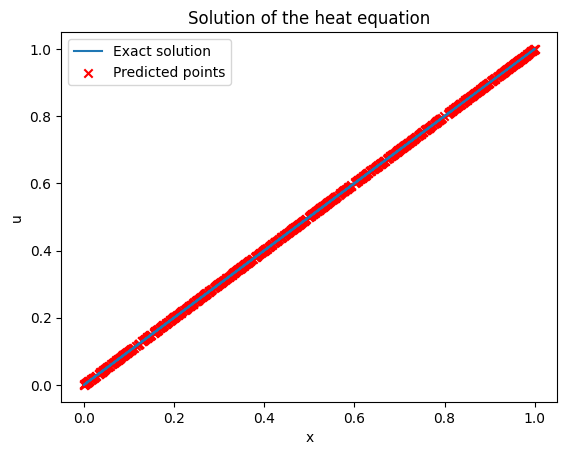

In [89]:
# Plot solution

# Test points, randomly distributed in the space domain
X_test = torch.rand(N_x, requires_grad=True)*(x_max - x_min) + x_min
X_test = X_test.reshape(N_x, 1)
X_test = X_test.to(device) # Send the inputs to the device (GPU or CPU)

# Predict the solution
u_predict = my_model(X_test)
u_check = my_model_checkpoint(X_test)
u_test = u_exact(X_test)

# Move tensors to CPU before converting to NumPy arrays
X_test = X_test.cpu().detach().numpy()
u_predict = u_predict.cpu().detach().numpy()
u_check = u_check.cpu().detach().numpy()
u_test = u_test.cpu().detach().numpy()

# Plot the solutions
plt.plot(X_test, u_test, label="Exact solution")
# plt.plot(X_test, u_predict, label="Predicted solution")
plt.scatter(X_test, u_predict, label="Predicted points", marker="x", color="red")
# plt.plot(X_test, u_check, label="Predicted solution checkpoint")

plt.xlabel("x")
plt.ylabel("u")
plt.legend()
plt.title("Solution of the heat equation")
plt.show()

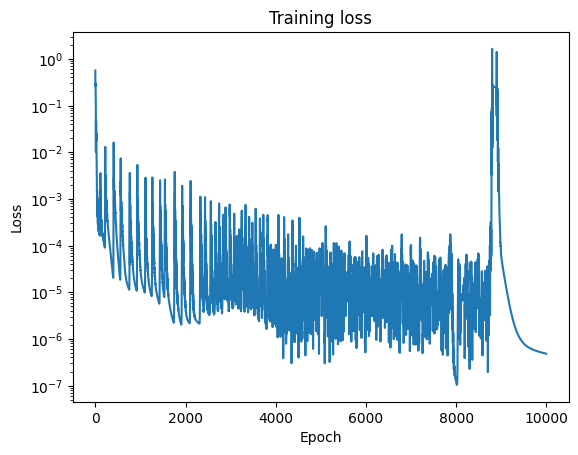

In [90]:
# Plot the training loss
# plt.plot(training_loss) # Linear scale
plt.semilogy(training_loss) # Log scale
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training loss")
plt.show()